This Jupyter notebook includes a simple design of a neural network using the [Keras](https://keras.io/) library. Keras is a high-level neural network library running on top of machine learning platforms such as TensorFlow.

This notebook also includes some tips and common practical functions when training a neural network.  At the end of this exercise you will have already implemented your first neural network in Python!




This notebook is based on the following [blog post](https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5) (you can check it for more details).

## TRAINING A NEURAL NETWORK

---

As usual, we first import the libraries that we are going to use, including now Keras.

**Note:** All these libraries need to be downloaded beforehand if not using Google Colab. Check their official websites for details on how to install them.

In [4]:
import numpy as np
import nltk
import sklearn
import keras
import requests
import random

We are going to use a dataset that contains mobile phone features. Our goal is to build a neural network that can predict the price range of a mobile phone given its features (e.g. batery power or whether it accepts dual sim or not). For this datasets four price ranges are used:

*   0 - low cost
*   1 - medium cost
*   2 - high cost
*   3 - very high cost

More information about the dataset can be found [here](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

We are going to load the dataset directly from the internet, but remember from the first semester that you can also load your dataset locally if you wish, or through Google Drive if using Google Colab:






In [5]:
url_train="http://josecamachocollados.com/mobilephone_train.csv" # Containing the training set of the mobile phone dataset, one phone per line
url_test="http://josecamachocollados.com/mobilephone_test.csv" # Containing the test set of the mobile phone dataset, one phone per line

#Load training set
response_train = requests.get(url_train)
dataset_file_train = response_train.text.split("\n")

#Load test set
response_test = requests.get(url_test)
dataset_file_test = response_test.text.split("\n")

The first line of each set contains all different feature names. Let's now print the features and the first five instances of the training set

In [6]:
print (dataset_file_train[0])
print ("  ----  \n")
for line in dataset_file_train[1:6]:
  print (line) 

battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
  ----  

842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


As usual, we are going to load the features in a vector form. In this case we are going to create a numpy matrix with the features and another one with the labels (i.e. the price in this case) for the training set.

In [7]:
dataset_train_noheader=dataset_file_train[1:] # We remove the header with the name of the features
random.shuffle(dataset_train_noheader) # We shuffle the instances of the dataset

len_dataset_train=len(dataset_train_noheader) # Number of instances in the training set
num_features_train=len(dataset_train_noheader[1].split(","))-1 # Number of features in the dataset
print ("The training set has "+str(len_dataset_train)+" instances and "+str(num_features_train)+" features per instance")

X_train=np.zeros((len_dataset_train,num_features_train)) # Initialization of the feature array of the training set
Y_train=np.zeros((len_dataset_train,1)) # Initialization of the label array of the training set
for i,line in enumerate(dataset_train_noheader):
  linesplit=line.strip().split(",")
  for j,feature in enumerate(linesplit[:-1]):
    X_train[i,j]=float(feature)
  Y_train[i,0]=int(linesplit[-1])
print ("Training set has now been loaded into a numpy matrix")

The training set has 1850 instances and 20 features per instance
Training set has now been loaded into a numpy matrix


**Note:** Remember that you can also load a csv file using [pandas](https://pandas.pydata.org) if you prefer.

**Excercise (Optional):** Repeat the same process to build the numpy training set by using pandas (`X_train` and `Y_train` should have the same values at the end).

One issue with most neural networks (and machine learning learning in general) is that they may not cope well with features with different ranges. To this end, it is often advisable to normalize all features to a common scale. We can do that using the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) of sklearn.

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)

Now we need to convert the labels into one-hot vectors. This is done to be able to integrate all possible predictions into the same vector. In our case, where we have four labels, each label will get converted to the following one-hot vector:

*   0 - (1,0,0,0)
*   1 - (0,1,0,0)
*   2 - (0,0,1,0)
*   3 - (0,0,0,1)

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
ohe = OneHotEncoder()
Y_train_onehot = ohe.fit_transform(Y_train).toarray()
size_output_onehot=len(Y_train_onehot[0])
print ("Size of the one-hot label vectors: "+str(size_output_onehot))
print (Y_train_onehot)

Size of the one-hot label vectors: 4
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


Now it's time to build our neural network! With Keras it is quite simple, but you still need to define the structure and size of your network. For example, let's build a neural network of one hidden layer with 15 dimensions.

In [12]:
from keras.models import Sequential
from keras.layers import Dense

In [13]:
model = Sequential() # This will be our neural network. Sequential means that the output of each layer is the input for the next one.
model.add(Dense(15, input_dim=num_features_train, activation='relu')) # Our network has as input the same number of features of the training set (i.e. 20 in our case).
model.add(Dense(size_output_onehot, activation='softmax')) # The output layer has in this case the same number of dimensions as our label one-hot vectors (i.e. 4 in our case).
print (model.summary()) # .summary shows an overview of our model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # This serves to define the loss function and optimizer.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                315       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 64        
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________
None


Let's now train our model! The process is similar as in sklearn, as we simply need to use the `.fit` function. Let's use 250 epochs for example (the number of epochs is the number of times our model will iterate through the entire training set).

**Note:** If the cell for training is run more than once, the model will start training from where it finished to train the previous time.

In [14]:
history = model.fit(X_train_norm, Y_train_onehot, epochs=250, batch_size=64)

===========] - 0s 607us/step - loss: 0.2586 - accuracy: 0.9449
Epoch 57/250
29/29 [==============================] - 0s 643us/step - loss: 0.2547 - accuracy: 0.9467
Epoch 58/250
29/29 [==============================] - 0s 607us/step - loss: 0.2414 - accuracy: 0.9499
Epoch 59/250
29/29 [==============================] - 0s 643us/step - loss: 0.2488 - accuracy: 0.9487
Epoch 60/250
29/29 [==============================] - 0s 750us/step - loss: 0.2278 - accuracy: 0.9557
Epoch 61/250
29/29 [==============================] - 0s 786us/step - loss: 0.2319 - accuracy: 0.9546
Epoch 62/250
29/29 [==============================] - 0s 750us/step - loss: 0.2310 - accuracy: 0.9495
Epoch 63/250
29/29 [==============================] - 0s 714us/step - loss: 0.2208 - accuracy: 0.9557
Epoch 64/250
29/29 [==============================] - 0s 643us/step - loss: 0.2200 - accuracy: 0.9581
Epoch 65/250
29/29 [==============================] - 0s 643us/step - loss: 0.2128 - accuracy: 0.9577
Epoch 66/250
29/29 

We can visually see how our model is training and its accuracy per epoch with the Python library [matplotlib](https://matplotlib.org/).

In [15]:
import matplotlib.pyplot as plt

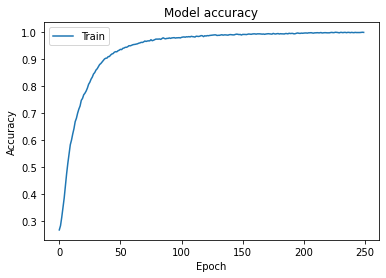

In [16]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Let's now check the performance of our trained model on the test data. For that, we need first to preprocess the test set as we did with the training set.

In [17]:
dataset_test_noheader=dataset_file_test[1:]
random.shuffle(dataset_test_noheader)

len_dataset_test=len(dataset_test_noheader) # Number of instances in the test set
num_features_test=len(dataset_test_noheader[1].split(","))-1 # Number of features in the test set (should be the same as the training set)
print ("The test set has "+str(len_dataset_test)+" instances and "+str(num_features_test)+" features per instance")

X_test=np.zeros((len_dataset_test,num_features_test)) # Initialization of the feature array of the test set
Y_test=np.zeros((len_dataset_test,1)) # Initialization of the label array of the test set
for i,line in enumerate(dataset_test_noheader):
  linesplit=line.strip().split(",")
  for j,feature in enumerate(linesplit[:-1]):
    X_test[i,j]=float(feature)
  Y_test[i,0]=int(linesplit[-1])
print ("Test set has now been loaded into a numpy matrix")
X_test_norm = sc.transform(X_test) # Finally, we normalized the features of the test set using our previously defined sc function.
Y_test_onehot = ohe.transform(Y_test).toarray() # We also transform the labels in the test set into the same one-hot vectors.

The test set has 150 instances and 20 features per instance
Test set has now been loaded into a numpy matrix


**Excercise (optional):** Define a function for: given a dataset with the same format as the mobine phone dataset as input, return the `X_train` and `Y_train` arrays used to trained our model. 

Then, once having the test set preprocessed, we can finally test our model. For this we can use the `.predict` function.

In [18]:
Y_pred = model.predict(X_test_norm)
preds = list()
for i in range(len(Y_pred)):
    preds.append(np.argmax(Y_pred[i])) #This serves to convert the hot encoded test label vectors to labels
Y_test_gold = list()
for i in range(len(Y_test_onehot)):
    Y_test_gold.append(np.argmax(Y_test_onehot[i]))

Let's now get the accuracy performance on the test set.

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
accuracy_test = accuracy_score(preds,Y_test_gold)
print('The accuracy in the test set is: '+str(round(accuracy_test,3)))

The accuracy in the test set is: 0.967


**Excercise 1:** Build another neural network using Keras, in this case with two hidden layers of 15 and 10 dimensions each and trained on 100 epochs. Train your model and get the output result in the test set.

In [21]:
model_2 = Sequential() # To complete...


**Exercise (optional):** Implement the same model but using a development set (you can split the training set into training and development for example). Then, use this development set to check the best performance per epoch and get the result of the model resulting from training until the best performing epoch. More details on how to do that can be found in the reference [blog post](https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5). 